Colormaps:
* PiYG
* PRGn
* BrBG
* Puor
* RoGy
* RoBu
* RoYIBu
* RoYIGn
* Spectral
* coolwarm
* bwr
* seismic

In [1]:
import ipypb
import logging
import warnings
import numpy as np
import matplotlib.pyplot as plt
from hdf5storage import loadmat

import torch
import radam
import torchaudio
import pytorch_lightning as pl

import dynamic_strf

device = torch.device('cuda:0')

logging.getLogger('radam').setLevel(logging.CRITICAL)
logging.getLogger('pytorch_lightning').setLevel(logging.CRITICAL)
logging.getLogger().setLevel(logging.CRITICAL)
warnings.simplefilter('ignore')

In [2]:
top_db = 70
out_sr = 100
freqbins = 64
x_noisy = []
for i in range(19):
    sound, in_sr = torchaudio.load(f'Data/Sounds/stim{i+1}.flac')
    spect = torch.nn.Sequential(
        torchaudio.transforms.MelSpectrogram(in_sr, n_fft=1024, hop_length=int(in_sr/out_sr), f_min=20, f_max=11025/2, n_mels=freqbins, power=2.0),
        torchaudio.transforms.AmplitudeToDB('power', top_db=top_db),
        type("Squeeze", (torch.nn.Module,), dict(forward=lambda self, x: x.squeeze(0).T.float()))()
        #type("Normalize", (torch.nn.Module,), dict(forward=lambda self, x: (x - x.max()).squeeze(0).T.float() / top_db + 1))()
    )(sound)
    x_noisy.append(spect)

y_noisy = []
path_fmt = 'Data/LIJ%s_data_TrainOn1If2Records.mat'
for subj_id in ['109', '110', '112', '113', '114', '120']:
    y_noisy.append(loadmat(path_fmt % subj_id)['noisy_resp'].squeeze(0))
y_noisy = [torch.cat([torch.from_numpy(y[i]) for y in y_noisy], dim=1) for i in range(19)]

for i in range(19):
    diff = len(x_noisy[i]) - len(y_noisy[i])
    if diff == 1:
        x_noisy[i] = x_noisy[i][:-1]
    elif diff > 1:
        raise RuntimeError(f'X and Y have different lengths for stim{i+1}!')
    
    x_noisy[i] = x_noisy[i][100:-50].float()
    y_noisy[i] = y_noisy[i][100:-50].float()

x_noisy = x_noisy[:4]
y_noisy = y_noisy[:4]

channels = y_noisy[0].shape[1]

In [ ]:
def builder():
    return dynamic_strf.modeling.SharedEncoder(
        input_size=freqbins,
        hidden_size=128,
        channels=channels
    ).to(device)

analyzer = dynamic_strf.Analyzer(
    builder=builder,
    data=(x_noisy, y_noisy),
    validation=None,
    jackknife=True,
    store_loc='5x128-jackknife-cv-toy',
    use_gpus=1,
    precision=16,
    device=device,
    verbose=2
)

dstrfs = analyzer.estimate_dstrfs()

In [ ]:
def builder():
    return dynamic_strf.modeling.SharedEncoder(
        input_size=freqbins,
        hidden_size=128,
        channels=channels
    ).to(device)

analyzer = dynamic_strf.Analyzer(
    builder=builder,
    data=(x_noisy, y_noisy),
    validation=None,
    jackknife=False,
    store_loc='5x128-cv-toy',
    use_gpus=1,
    precision=16,
    device=device,
    verbose=2
)

dstrfs = analyzer.estimate_dstrfs()

In [2]:
top_db = 70
out_sr = 100
freqbins = 64
x_noisy = []
for i in range(19):
    sound, in_sr = torchaudio.load(f'Data/Sounds/stim{i+1}.flac')
    spect = torch.nn.Sequential(
        torchaudio.transforms.MelSpectrogram(in_sr, n_fft=1024, hop_length=int(in_sr/out_sr), f_min=20, f_max=11025/2, n_mels=freqbins, power=2.0),
        torchaudio.transforms.AmplitudeToDB('power', top_db=top_db),
        type("Squeeze", (torch.nn.Module,), dict(forward=lambda self, x: x.squeeze(0).T.float()))()
        #type("Normalize", (torch.nn.Module,), dict(forward=lambda self, x: (x - x.max()).squeeze(0).T.float() / top_db + 1))()
    )(sound)
    x_noisy.append(spect)

y_noisy = []
path_fmt = 'Data/LIJ%s_data_TrainOn1If2Records.mat'
for subj_id in ['109', '110', '112', '113', '114', '120']:
    y_noisy.append(loadmat(path_fmt % subj_id)['noisy_resp'].squeeze(0))
y_noisy = [torch.cat([torch.from_numpy(y[i]) for y in y_noisy], dim=1) for i in range(19)]

for i in range(19):
    diff = len(x_noisy[i]) - len(y_noisy[i])
    if diff == 1:
        x_noisy[i] = x_noisy[i][:-1]
    elif diff > 1:
        raise RuntimeError(f'X and Y have different lengths for stim{i+1}!')
    
    x_noisy[i] = x_noisy[i][100:-50].float()
    y_noisy[i] = y_noisy[i][100:-50].float()

x_noisy = x_noisy[:5]
y_noisy = y_noisy[:5]

channels = y_noisy[0].shape[1]

In [3]:
def builder():
    return dynamic_strf.modeling.SharedEncoder(
        input_size=freqbins,
        hidden_size=128,
        channels=channels
    ).to(device)

analyzer = dynamic_strf.Analyzer(
    builder=builder,
    data=(x_noisy[:4], y_noisy[:4]),
    validation=(x_noisy[-1:], y_noisy[-1:]),
    jackknife=False,
    store_loc='5x128-toy',
    use_gpus=1,
    precision=16,
    device=device,
    verbose=2
)

dstrfs = analyzer.estimate_dstrfs()

II: Storing results under ./5x128-toy/
Fitting model for leave out: []... 
Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s, loss=0.933]
Done.
Computing dSTRFs for stimulus 01/01 (jackknife = 1)... 

 [████████████████████████████████████████████████████████████] 65/65 [31:26<00:03, 29.02s/it]

Done.


In [4]:
def builder():
    return dynamic_strf.modeling.SharedEncoder(
        input_size=freqbins,
        hidden_size=128,
        channels=channels
    ).to(device)

analyzer = dynamic_strf.Analyzer(
    builder=builder,
    data=(x_noisy[:4], y_noisy[:4]),
    validation=(x_noisy[-1:], y_noisy[-1:]),
    jackknife=True,
    store_loc='5x128-jackknife-toy',
    use_gpus=1,
    precision=16,
    device=device,
    verbose=2
)

dstrfs = analyzer.estimate_dstrfs()

II: Storing results under ./5x128-jackknife-toy/
Fitting model for leave out: [0]... 
Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s, loss=0.85] 
Done.
Fitting model for leave out: [1]... 
Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, loss=0.893]
Done.
Fitting model for leave out: [2]... 
Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s, loss=0.859]
Done.
Fitting model for leave out: [3]... 
Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s, loss=0.894]
Done.
Computing dSTRFs for stimulus 01/01 (jackknife = 4)... 

 [████████████████████████████████████████████████████████████] 65/65 [02:05:28<00:14, 115.81s/it]

Done.


In [2]:
top_db = 70
out_sr = 100
freqbins = 64
x_noisy = []
for i in range(19):
    sound, in_sr = torchaudio.load(f'Data/Sounds/stim{i+1}.flac')
    spect = torch.nn.Sequential(
        torchaudio.transforms.MelSpectrogram(in_sr, n_fft=1024, hop_length=int(in_sr/out_sr), f_min=20, f_max=11025/2, n_mels=freqbins, power=2.0),
        torchaudio.transforms.AmplitudeToDB('power', top_db=top_db),
        type("Squeeze", (torch.nn.Module,), dict(forward=lambda self, x: x.squeeze(0).T.float()))()
        #type("Normalize", (torch.nn.Module,), dict(forward=lambda self, x: (x - x.max()).squeeze(0).T.float() / top_db + 1))()
    )(sound)
    x_noisy.append(spect)

y_noisy = []
path_fmt = 'Data/LIJ%s_data_TrainOn1If2Records.mat'
for subj_id in ['109', '110', '112', '113', '114', '120']:
    y_noisy.append(loadmat(path_fmt % subj_id)['noisy_resp'].squeeze(0))
y_noisy = [torch.cat([torch.from_numpy(y[i]) for y in y_noisy], dim=1) for i in range(19)]

for i in range(19):
    diff = len(x_noisy[i]) - len(y_noisy[i])
    if diff == 1:
        x_noisy[i] = x_noisy[i][:-1]
    elif diff > 1:
        raise RuntimeError(f'X and Y have different lengths for stim{i+1}!')
    
    x_noisy[i] = x_noisy[i][100:-50].float()
    y_noisy[i] = y_noisy[i][100:-50].float()

x_noisy = x_noisy[:-1]
y_noisy = y_noisy[:-1]

channels = y_noisy[0].shape[1]

In [ ]:
def builder():
    return dynamic_strf.modeling.SharedEncoder(
        input_size=freqbins,
        hidden_size=128,
        channels=channels
    ).to(device)

dynamic_strf.modeling.fit_multiple(
    builder=builder,
    data=(x_noisy, y_noisy),
    crossval=True,
    jackknife=True,
    save_dir='5x128-jackknife-cv',
    batch_size=64,
    num_workers=4,
    gpus=1,
    precision=16,
    verbose=1
)

model = builder()

dynamic_strf.estimate.dSTRF_multiple(
    model=model,
    checkpoints='5x128-jackknife-cv',
    data=(x_noisy, y_noisy),
    crossval=True,
    jackknife=True,
    save_dir='5x128-jackknife-cv-dstrf',
    chunk_size=100,
    verbose=1
)

scores = dynamic_strf.modeling.test_multiple(
    modle=builder(),
    checkpoints='5x128-jackknife-cv',
    data=(x_noisy, y_noisy),
    crossval=True,
    jackknife=True,
    verbose=1
)

nonlin = dynamic_strf.estimate.nonlinearities(
    paths='5x128-jackknife-cv-dstrf',
    reduction='mean',
    verbose=0
)

Directory "5x128-jackknife-cv" already exists.
Fitting model for leave out: [0, 1]... Skip.
Fitting model for leave out: [0, 2]... Skip.
Fitting model for leave out: [0, 3]... Skip.
Fitting model for leave out: [0, 4]... Skip.
Fitting model for leave out: [0, 5]... Skip.
Fitting model for leave out: [0, 6]... Skip.
Fitting model for leave out: [0, 7]... Skip.
Fitting model for leave out: [0, 8]... Skip.
Fitting model for leave out: [0, 9]... Skip.
Fitting model for leave out: [0, 10]... Skip.
Fitting model for leave out: [0, 11]... Skip.
Fitting model for leave out: [0, 12]... Skip.
Fitting model for leave out: [0, 13]... Skip.
Fitting model for leave out: [0, 14]... Skip.
Fitting model for leave out: [0, 15]... Skip.
Fitting model for leave out: [0, 16]... Skip.
Fitting model for leave out: [0, 17]... Skip.
Fitting model for leave out: [1, 2]... Skip.
Fitting model for leave out: [1, 3]... Skip.
Fitting model for leave out: [1, 4]... Skip.
Fitting model for leave out: [1, 5]... Skip.


In [ ]:
def builder():
    return dynamic_strf.modeling.SharedEncoder(
        input_size=freqbins,
        hidden_size=128,
        channels=channels
    ).to(device)

analyzer = dynamic_strf.Analyzer(
    builder=builder,
    data=(x_noisy, y_noisy),
    validation=None,
    jackknife=True,
    store_loc='5x128-jackknife-cv',
    use_gpus=1,
    precision=16,
    device=device,
    verbose=2
)

dstrfs = analyzer.estimate_dstrfs()

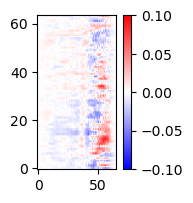

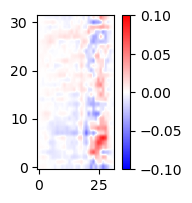

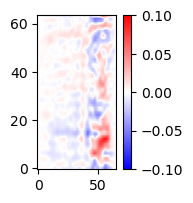

In [56]:
t = 490
plt.figure(figsize=(2, 2))
plt.imshow(a[0,t,10].T, aspect=2, origin='lower', cmap='bwr', vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(q[t].T, aspect=2, origin='lower', cmap='bwr', vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(w[t].T, aspect=2, origin='lower', cmap='bwr', vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.show()

In [83]:
x_noisy[1].sum(dim=0)

tensor([1603.5094, 2224.9441, 2522.7830, 2418.3677, 2552.1001, 2779.7356,
        2735.9729, 2638.3569, 2594.7400, 2513.9153, 2565.0085, 2594.6069,
        2677.7141, 2713.1914, 2720.9407, 2636.3655, 2495.6526, 2473.8452,
        2509.0886, 2511.1296, 2422.7930, 2422.7085, 2460.8198, 2400.0654,
        2388.9067, 2376.4690, 2354.6853, 2357.5684, 2296.4399, 2282.8081,
        2240.0254, 2164.0554, 2163.5317, 2194.8462, 2156.1895, 2138.8560,
        2127.8030, 2060.9878, 2034.7134, 1997.9180, 2013.1299, 1962.9333,
        1954.5483, 2032.0822, 2119.0483, 2152.5698, 2156.9314, 2108.1567,
        1931.0961, 1944.3579, 1897.2159, 1915.4143, 1900.7834, 1831.8208,
        1778.5070, 1710.7621, 1638.3660, 1573.5435, 1425.7031, 1223.1151,
        1121.9265, 1095.9299, 1072.9152,  808.5877])

In [10]:
!ls -lh tmp-06

model-0.pt  model-2.pt	model-4.pt  model-6.pt	model-8.pt
model-1.pt  model-3.pt	model-5.pt  model-7.pt


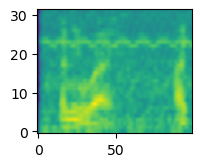

In [8]:
plt.figure(figsize=(2, 2))
plt.imshow(x_noisy[1][0:100].T, origin='lower', aspect=2.5)
plt.show()

In [ ]:
analyzer = dSTRF.Analyzer(
    builder=builder,
    data=(x_noisy, y_noisy),
    validation=None,
    jackknife=True,
    store_loc='tmp-02',
    use_gpus=1,
    precision=16,
    device=device,
)

analyzer.estimate_dstrfs()

In [ ]:
num_epochs = 1000

losses_tr = []
losses_dev = []
scores_dev = []
for jack_idx in ipypb.irange(1, 19):
    model = Encoder(num_outputs=channels).to(device)
    criterion = torch.nn.MSELoss(reduction='mean')
    # optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1)
    optimizer = radam.RAdam(model.parameters(), lr=1e-3, weight_decay=0.3)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.996)
    
    losses_tr.append([])
    losses_dev.append([])
    scores_dev.append([])
    for epoch in ipypb.irange(num_epochs):
        loss = 0.0
        model.train()
        for i in range(1, 19):
            if i == jack_idx:
                continue
            
            z_tr = model(x_noisy[i].to(device))
            loss += criterion(z_tr, y_noisy[i].to(device))
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        scheduler.step()
        losses_tr[-1].append(loss.item())
        
        model.eval()
        with torch.set_grad_enabled(False):
            z_dev = model(x_noisy[0].to(device))
            loss = criterion(z_dev, y_noisy[0].to(device))
            score = corr(z_dev, y_noisy[0].to(device), axis=0)#.mean()
        losses_dev[-1].append(loss.detach().cpu())
        scores_dev[-1].append(score.detach().cpu())
    
    losses_tr[-1] = torch.tensor(losses_tr[-1])
    losses_dev[-1] = torch.tensor(losses_dev[-1])
    scores_dev[-1] = torch.stack(scores_dev[-1], dim=0)
    
    torch.save(model.state_dict(), f'models/jack_{jack_idx:02d}.pt')

torch.save((losses_tr, losses_dev, scores_dev), 'models/log.pt')

 [█████████████████████████████████###########################] 10/18 [12:14:41<01:12:58, 4408.11s/it]

 [████████████████████████████████████████████████████████████] 1000/1000 [01:13:46<00:04, 4.43s/it]

 [████████████████████████████████████████████████████████████] 1000/1000 [01:13:49<00:04, 4.43s/it]

 [████████████████████████████████████████████████████████████] 1000/1000 [01:13:43<00:04, 4.42s/it]

 [████████████████████████████████████████████████████████████] 1000/1000 [01:13:46<00:04, 4.43s/it]

 [█████████████████████████████████████████████████###########] 830/1000 [01:00:49<00:04, 4.40s/it]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 [████████████████████████████████████████████████████████████] 1000/1000 [01:13:37<00:04, 4.42s/it]

 [████████████████████████████████████████████████████████████] 1000/1000 [01:12:56<00:04, 4.38s/it]

 [████████████████████████####################################] 413/1000 [30:14<00:04, 4.39s/it]

In [128]:
receptive_field = 65

@torch.no_grad()
def compute_jacobian_dstrf_movie(coder, x_tr):
    dstrf_movie = []
    chunk_size=1000
    chunk_start = 0
    overlap = 100
    move_back = 0
    while chunk_start-overlap < x_tr.shape[0]:
        
        # check to make sure there is enough room in this chunk for all the kernels
        # and if there's not, move the start back for this last chunk only
        if chunk_start > 0 and (x_tr.shape[0] - chunk_start < 150):
            move_back = 100
            chunk_start -= move_back
        
        jacobian = torch.autograd.functional.jacobian(coder, x_tr[chunk_start:chunk_start+chunk_size])
        
        if chunk_start == 0:
            start_point = 0
        else:
            start_point = overlap
            
        for time_point in range(start_point+move_back, jacobian.shape[0]):
            dstrf = jacobian[time_point,0,max(time_point-receptive_field+1,0):time_point+1,:].T
            if dstrf.shape[1] < receptive_field:
                dstrf = torch.nn.functional.pad(dstrf, [receptive_field-dstrf.shape[1], 0, 0, 0])
            dstrf_movie.append(dstrf) # dstrf is shape 23 * receptive_field
            
            del dstrf
            
        chunk_start += chunk_size - overlap
        
        del jacobian
        
        
    return torch.cat([frame.unsqueeze(0) for frame in dstrf_movie], dim=0) # shape (time,23,receptive_field)
    

@torch.no_grad()
def compute_jackknife_dstrf(dstrf_movies, threshold_count=19):
    '''
    This function computes the average dstrf_movie and zeros out pixels
    for which less than 19/20 of the dstrf movies agree (i.e. 19/20 are positive
    or 19/20 are negative).
    
    Inputs
    ------
    dstrf_movies: torch tensor, shape (20, time, 23, receptive_field)
    
    Returns
    -------
    avg_movie: torch tensor, shape (time, 23, receptive_field)
    '''
    
    avg_movie = torch.mean(dstrf_movies, dim=0)
    
    sign_movies = torch.where(dstrf_movies>0, 1., 0.) # 1 where positive, 0 where negative or 0
    sign_sum = torch.sum(sign_movies, 0) # sum over all the jackknifes (sum over 20 frames if 20 jackknife)

    # zero out the regions that don't have at least threshold_count in agreement
    avg_movie = torch.where((avg_movie>0) & (sign_sum < threshold_count), torch.zeros(1, dtype=torch.float32).to(device), avg_movie)
    avg_movie = torch.where((avg_movie<0) & (sign_sum > dstrf_movies.shape[0]-threshold_count), torch.zeros(1, dtype=torch.float32).to(device), avg_movie)

    return avg_movie

In [220]:
Q = compute_jacobian_dstrf_movie(model, x_dev[200:300])

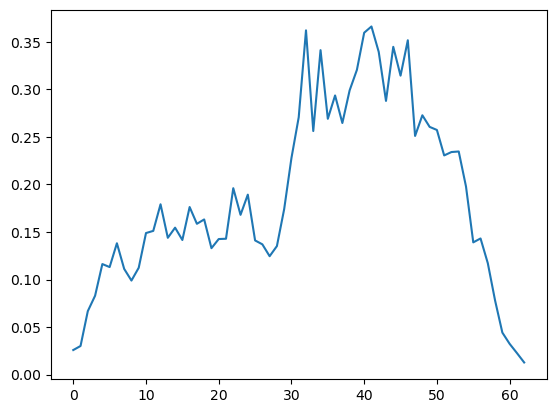

In [221]:
plt.plot(Q[80].abs().sum(0).cpu())
plt.show()

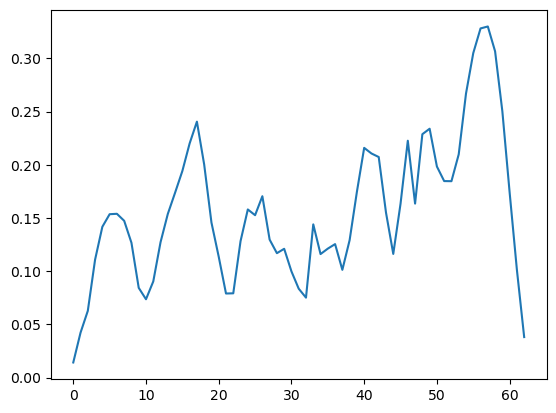

In [209]:
plt.plot(Q[80].abs().sum(0).cpu())
plt.show()

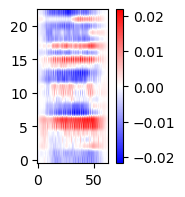

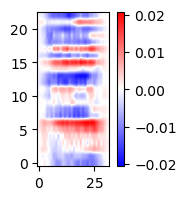

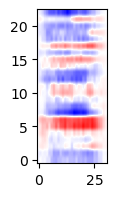

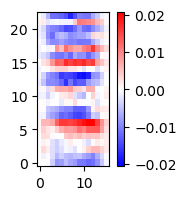

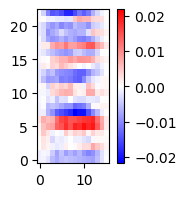

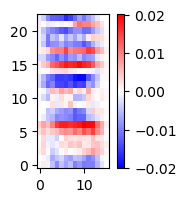

In [222]:
plt.figure(figsize=(2, 2))
plt.imshow(Q[65:].mean(0).cpu(), aspect=6, vmin=-Q[65:].mean(0).cpu().abs().max(), vmax=Q[65:].mean(0).cpu().abs().max(), origin='lower', cmap='bwr')
plt.colorbar()
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(Q[65:].mean(0)[:,0::2].cpu(), aspect=3, vmin=-Q[65:].mean(0)[:,0::2].cpu().abs().max(), vmax=Q[65:].mean(0)[:,0::2].cpu().abs().max(), origin='lower', cmap='bwr')
plt.colorbar()
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(Q[65:].mean(0)[:,1::2].cpu(), aspect=3, vmin=-Q[65:].mean(0)[:,1::2].cpu().abs().max(), vmax=Q[65:].mean(0)[:,1::2].cpu().abs().max(), origin='lower', cmap='bwr')
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(Q[65:].mean(0)[:,0::4].cpu(), aspect=1.5, vmin=-Q[65:].mean(0)[:,0::4].cpu().abs().max(), vmax=Q[65:].mean(0)[:,0::4].cpu().abs().max(), origin='lower', cmap='bwr')
plt.colorbar()
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(Q[65:].mean(0)[:,1::4].cpu(), aspect=1.5, vmin=-Q[65:].mean(0)[:,1::4].cpu().abs().max(), vmax=Q[65:].mean(0)[:,1::4].cpu().abs().max(), origin='lower', cmap='bwr')
plt.colorbar()
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(Q[65:].mean(0)[:,2::4].cpu(), aspect=1.5, vmin=-Q[65:].mean(0)[:,2::4].cpu().abs().max(), vmax=Q[65:].mean(0)[:,2::4].cpu().abs().max(), origin='lower', cmap='bwr')
plt.colorbar()
plt.show()

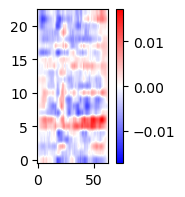

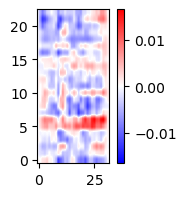

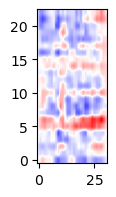

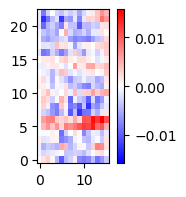

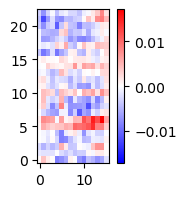

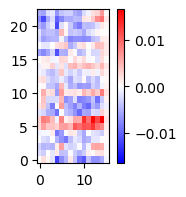

In [210]:
plt.figure(figsize=(2, 2))
plt.imshow(Q[65:].mean(0).cpu(), aspect=6, vmin=-Q[65:].mean(0).cpu().abs().max(), vmax=Q[65:].mean(0).cpu().abs().max(), origin='lower', cmap='bwr')
plt.colorbar()
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(Q[65:].mean(0)[:,0::2].cpu(), aspect=3, vmin=-Q[65:].mean(0)[:,0::2].cpu().abs().max(), vmax=Q[65:].mean(0)[:,0::2].cpu().abs().max(), origin='lower', cmap='bwr')
plt.colorbar()
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(Q[65:].mean(0)[:,1::2].cpu(), aspect=3, vmin=-Q[65:].mean(0)[:,1::2].cpu().abs().max(), vmax=Q[65:].mean(0)[:,1::2].cpu().abs().max(), origin='lower', cmap='bwr')
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(Q[65:].mean(0)[:,0::4].cpu(), aspect=1.5, vmin=-Q[65:].mean(0)[:,0::4].cpu().abs().max(), vmax=Q[65:].mean(0)[:,0::4].cpu().abs().max(), origin='lower', cmap='bwr')
plt.colorbar()
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(Q[65:].mean(0)[:,1::4].cpu(), aspect=1.5, vmin=-Q[65:].mean(0)[:,1::4].cpu().abs().max(), vmax=Q[65:].mean(0)[:,1::4].cpu().abs().max(), origin='lower', cmap='bwr')
plt.colorbar()
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(Q[65:].mean(0)[:,2::4].cpu(), aspect=1.5, vmin=-Q[65:].mean(0)[:,2::4].cpu().abs().max(), vmax=Q[65:].mean(0)[:,2::4].cpu().abs().max(), origin='lower', cmap='bwr')
plt.colorbar()
plt.show()

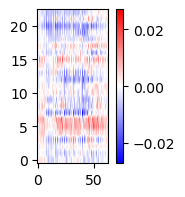

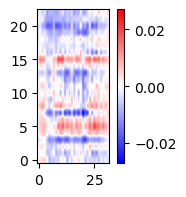

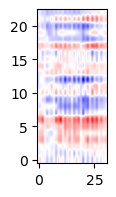

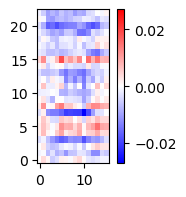

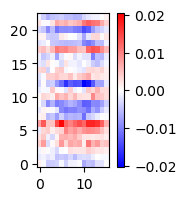

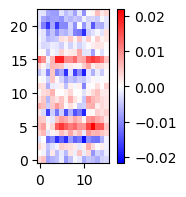

In [205]:
plt.figure(figsize=(2, 2))
plt.imshow(Q[65:].mean(0).cpu(), aspect=6, vmin=-Q[65:].mean(0).cpu().abs().max(), vmax=Q[65:].mean(0).cpu().abs().max(), origin='lower', cmap='bwr')
plt.colorbar()
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(Q[65:].mean(0)[:,0::2].cpu(), aspect=3, vmin=-Q[65:].mean(0)[:,0::2].cpu().abs().max(), vmax=Q[65:].mean(0)[:,0::2].cpu().abs().max(), origin='lower', cmap='bwr')
plt.colorbar()
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(Q[65:].mean(0)[:,1::2].cpu(), aspect=3, vmin=-Q[65:].mean(0)[:,1::2].cpu().abs().max(), vmax=Q[65:].mean(0)[:,1::2].cpu().abs().max(), origin='lower', cmap='bwr')
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(Q[65:].mean(0)[:,0::4].cpu(), aspect=1.5, vmin=-Q[65:].mean(0)[:,0::4].cpu().abs().max(), vmax=Q[65:].mean(0)[:,0::4].cpu().abs().max(), origin='lower', cmap='bwr')
plt.colorbar()
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(Q[65:].mean(0)[:,1::4].cpu(), aspect=1.5, vmin=-Q[65:].mean(0)[:,1::4].cpu().abs().max(), vmax=Q[65:].mean(0)[:,1::4].cpu().abs().max(), origin='lower', cmap='bwr')
plt.colorbar()
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(Q[65:].mean(0)[:,2::4].cpu(), aspect=1.5, vmin=-Q[65:].mean(0)[:,2::4].cpu().abs().max(), vmax=Q[65:].mean(0)[:,2::4].cpu().abs().max(), origin='lower', cmap='bwr')
plt.colorbar()
plt.show()

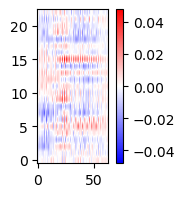

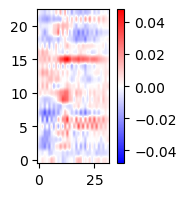

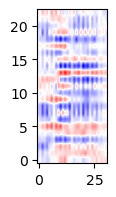

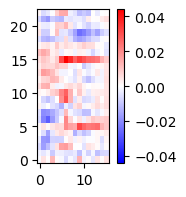

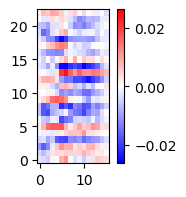

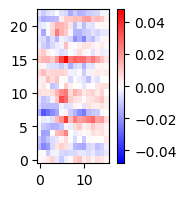

In [191]:
plt.figure(figsize=(2, 2))
plt.imshow(Q[65:].mean(0).cpu(), aspect=6, vmin=-Q[65:].mean(0).cpu().abs().max(), vmax=Q[65:].mean(0).cpu().abs().max(), origin='lower', cmap='bwr')
plt.colorbar()
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(Q[65:].mean(0)[:,0::2].cpu(), aspect=3, vmin=-Q[65:].mean(0)[:,0::2].cpu().abs().max(), vmax=Q[65:].mean(0)[:,0::2].cpu().abs().max(), origin='lower', cmap='bwr')
plt.colorbar()
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(Q[65:].mean(0)[:,1::2].cpu(), aspect=3, vmin=-Q[65:].mean(0)[:,1::2].cpu().abs().max(), vmax=Q[65:].mean(0)[:,1::2].cpu().abs().max(), origin='lower', cmap='bwr')
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(Q[65:].mean(0)[:,0::4].cpu(), aspect=1.5, vmin=-Q[65:].mean(0)[:,0::4].cpu().abs().max(), vmax=Q[65:].mean(0)[:,0::4].cpu().abs().max(), origin='lower', cmap='bwr')
plt.colorbar()
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(Q[65:].mean(0)[:,1::4].cpu(), aspect=1.5, vmin=-Q[65:].mean(0)[:,1::4].cpu().abs().max(), vmax=Q[65:].mean(0)[:,1::4].cpu().abs().max(), origin='lower', cmap='bwr')
plt.colorbar()
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(Q[65:].mean(0)[:,2::4].cpu(), aspect=1.5, vmin=-Q[65:].mean(0)[:,2::4].cpu().abs().max(), vmax=Q[65:].mean(0)[:,2::4].cpu().abs().max(), origin='lower', cmap='bwr')
plt.colorbar()
plt.show()

In [51]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size=23, hidden_size=128, num_outputs=2, channels=1, activation='linear'):
        super().__init__()
        
        self.input_size = input_size
        self.channels = channels
        self.activation = activation

        self.conv_shared = torch.nn.Sequential(
            torch.nn.Conv1d(input_size, hidden_size, 3, dilation=1, bias=False),
            torch.nn.ReLU(),
            torch.nn.Conv1d(hidden_size, hidden_size, 3, dilation=2, bias=False),
            torch.nn.ReLU(),
            torch.nn.Conv1d(hidden_size, hidden_size, 3, dilation=4, bias=False),
            torch.nn.ReLU(),
        )
        
        self.conv_branched = torch.nn.ModuleList([torch.nn.Sequential(
            torch.nn.Conv1d(hidden_size, hidden_size, 3, dilation=8, bias=False),
            torch.nn.ReLU(),
            torch.nn.Conv1d(hidden_size, hidden_size, 3, dilation=16, bias=False),
            torch.nn.ReLU(),
            torch.nn.Conv1d(hidden_size, channels, 1, bias=True) ) for _ in range(num_outputs)])
        
        if activation == 'relu':
            for conv in self.conv_branched:
                conv.add_module(torch.nn.LeakyReLU())
                conv.add_module(torch.nn.Conv1d(channels, channels, 1, groups=channels, bias=True))
        elif activation != 'linear' and activation != 'none':
            raise RuntimeError(f'Unknown activation: {activation}')
        
        if hasattr(self.conv_branched[0], 'bias'):
            for conv in self.conv_branched:
                torch.nn.init.constant_(conv.bias.weight, 1.0)
                torch.nn.init.constant_(conv.bias.bias, 0.0)
    
    def forward(self, x):
        x = torch.nn.functional.pad(x, (0, 0, 62, 0)).float()
        x = x.T.unsqueeze(0)
        x = self.conv_shared(x)
        output = [conv(x).squeeze(0).T for conv in self.conv_branched]
        # x = x.squeeze(0).T
        output = torch.cat(output, dim=-1)
        return output
    
    def to(self, device):
        super().to(device)
        self._device = device
        return self
    
    @property
    def device(self):
        return self._device

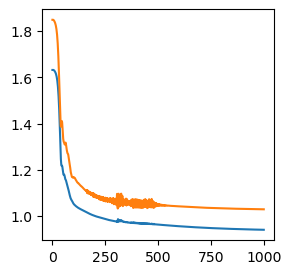

last(losses_dev) = 1.0288
average corr = 0.3599


In [202]:
model = Encoder(num_outputs=y_noisy[0].shape[1]).to(device)
criterion = torch.nn.MSELoss(reduction='mean')
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1)
optimizer = radam.RAdam(model.parameters(), lr=1e-3, weight_decay=0.3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.996)

num_epochs = 1000

losses_tr, losses_dev = [], []
for epoch in range(num_epochs):
    loss = 0.0
    for i in range(1, 19):
        x_tr = torch.from_numpy(x_noisy[i]).float().to(device)
        y_tr = torch.from_numpy(y_noisy[i]).float().to(device)
        z_tr = model(x_tr)
        loss += criterion(z_tr, y_tr)
    
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
    optimizer.step()
    scheduler.step()
    losses_tr.append(loss.item())
    
    with torch.set_grad_enabled(False):
        x_dev = torch.from_numpy(x_noisy[0]).float().to(device)
        y_dev = torch.from_numpy(y_noisy[0]).float().to(device)
        z_dev = model(x_dev)
        loss = criterion(z_dev, y_dev)
    losses_dev.append(loss.item())

plt.figure(figsize=(3, 3))
plt.plot(np.array(losses_tr) / 18)
plt.plot(losses_dev)
plt.show()

print(f'last(losses_dev) = {criterion(z_dev, y_dev).item():.4f}')
print(f'average corr = {corr(z_dev, y_dev, axis=0).mean().item():.4f}')

In [206]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size=23, hidden_size=128, num_outputs=2, channels=1, activation='linear'):
        super().__init__()
        
        self.input_size = input_size
        self.channels = channels
        self.activation = activation

        self.conv_shared = torch.nn.Sequential(
            torch.nn.Conv1d(input_size, hidden_size, 3, dilation=1, bias=False),
            torch.nn.ReLU(),
            torch.nn.Conv1d(hidden_size, hidden_size, 5, dilation=1, bias=False),
            torch.nn.ReLU(),
            torch.nn.Conv1d(hidden_size, hidden_size, 9, dilation=1, bias=False),
            torch.nn.ReLU(),
        )
        
        self.conv_branched = torch.nn.ModuleList([torch.nn.Sequential(
            torch.nn.Conv1d(hidden_size, hidden_size, 3, dilation=8, bias=False),
            torch.nn.ReLU(),
            torch.nn.Conv1d(hidden_size, hidden_size, 3, dilation=16, bias=False),
            torch.nn.ReLU(),
            torch.nn.Conv1d(hidden_size, channels, 1, bias=True) ) for _ in range(num_outputs)])
        
        if activation == 'relu':
            for conv in self.conv_branched:
                conv.add_module(torch.nn.LeakyReLU())
                conv.add_module(torch.nn.Conv1d(channels, channels, 1, groups=channels, bias=True))
        elif activation != 'linear' and activation != 'none':
            raise RuntimeError(f'Unknown activation: {activation}')
        
        if hasattr(self.conv_branched[0], 'bias'):
            for conv in self.conv_branched:
                torch.nn.init.constant_(conv.bias.weight, 1.0)
                torch.nn.init.constant_(conv.bias.bias, 0.0)
    
    def forward(self, x):
        x = torch.nn.functional.pad(x, (0, 0, 62, 0)).float()
        x = x.T.unsqueeze(0)
        x = self.conv_shared(x)
        output = [conv(x).squeeze(0).T for conv in self.conv_branched]
        # x = x.squeeze(0).T
        output = torch.cat(output, dim=-1)
        return output
    
    def to(self, device):
        super().to(device)
        self._device = device
        return self
    
    @property
    def device(self):
        return self._device

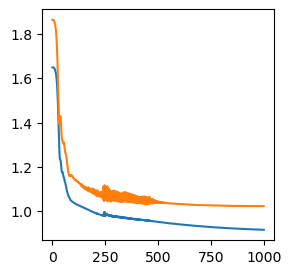

last(losses_dev) = 1.0228
average corr = 0.3632


In [207]:
model = Encoder(num_outputs=y_noisy[0].shape[1]).to(device)
criterion = torch.nn.MSELoss(reduction='mean')
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1)
optimizer = radam.RAdam(model.parameters(), lr=1e-3, weight_decay=0.3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.996)

num_epochs = 1000

losses_tr, losses_dev = [], []
for epoch in range(num_epochs):
    loss = 0.0
    for i in range(1, 19):
        x_tr = torch.from_numpy(x_noisy[i]).float().to(device)
        y_tr = torch.from_numpy(y_noisy[i]).float().to(device)
        z_tr = model(x_tr)
        loss += criterion(z_tr, y_tr)
        
        x_tr = torch.from_numpy(x_clean[i]).float().to(device)
        y_tr = torch.from_numpy(y_clean[i]).float().to(device)
        z_tr = model(x_tr)
        loss += criterion(z_tr, y_tr)
    
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
    optimizer.step()
    scheduler.step()
    losses_tr.append(loss.item())
    
    with torch.set_grad_enabled(False):
        x_dev = torch.from_numpy(x_noisy[0]).float().to(device)
        y_dev = torch.from_numpy(y_noisy[0]).float().to(device)
        z_dev = model(x_dev)
        loss = criterion(z_dev, y_dev)
    losses_dev.append(loss.item())

plt.figure(figsize=(3, 3))
plt.plot(np.array(losses_tr) / 36)
plt.plot(losses_dev)
plt.show()

print(f'last(losses_dev) = {criterion(z_dev, y_dev).item():.4f}')
print(f'average corr = {corr(z_dev, y_dev, axis=0).mean().item():.4f}')